In [165]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import random 
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import matplotlib.pyplot as plt

In [166]:
# sample_fraction = 0.2

# def skip_row(row_idx):
#     if row_idx == 0:
#         return False
#     return random.random() > sample_fraction
    
random.seed(42)    
df = pd.read_csv('OneDrive/Desktop/US_Accidents_March23.csv')


In [167]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     7728394 non-null  object 
 1   Source                 7728394 non-null  object 
 2   Severity               7728394 non-null  int64  
 3   Start_Time             7728394 non-null  object 
 4   End_Time               7728394 non-null  object 
 5   Start_Lat              7728394 non-null  float64
 6   Start_Lng              7728394 non-null  float64
 7   End_Lat                4325632 non-null  float64
 8   End_Lng                4325632 non-null  float64
 9   Distance(mi)           7728394 non-null  float64
 10  Description            7728389 non-null  object 
 11  Street                 7717525 non-null  object 
 12  City                   7728141 non-null  object 
 13  County                 7728394 non-null  object 
 14  State             

In [168]:
missingvalues = df.isna().sum()
missingvalues = missingvalues/ len(df) * 100
missingvalues[missingvalues.sort_values(ascending = False) > 0]


End_Lat                  44.029355
End_Lng                  44.029355
Description               0.000065
Street                    0.140637
City                      0.003274
Zipcode                   0.024779
Timezone                  0.101030
Airport_Code              0.292881
Weather_Timestamp         1.555666
Temperature(F)            2.120143
Wind_Chill(F)            25.865904
Humidity(%)               2.253301
Pressure(in)              1.820288
Visibility(mi)            2.291524
Wind_Direction            2.267043
Wind_Speed(mph)           7.391355
Precipitation(in)        28.512858
Weather_Condition         2.244438
Sunrise_Sunset            0.300787
Civil_Twilight            0.300787
Nautical_Twilight         0.300787
Astronomical_Twilight     0.300787
dtype: float64

In [169]:
#dropping End_lat and End_Lng since it is missing around 50% of the time
df = df.drop(columns = ['End_Lat', 'End_Lng'])

In [170]:
#for precipitation, wind_chill and wind_speed, i will input the null values with the mean of the values as
#dropping the null rows will take out too much of the data

df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].mean())
df['Wind_Chill(F)']= df['Wind_Chill(F)'].fillna(df['Wind_Chill(F)'].mean())
df['Wind_Speed(mph)']=df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].mean())

In [171]:
#for the rest of the values, since it is around 2% of the value, dropping the rows with the null value would be best to prevent
#data from being more skewed

df = df.dropna(subset = ['Street', 'City', 'Zipcode', 'Timezone', 'Airport_Code','Description',
       'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'])

In [172]:
#transforming Dates to datetime
df['Start_Time'] =pd.to_datetime(df['Start_Time'].str.split('.').str[0])
df['End_Time'] =pd.to_datetime(df['End_Time'].str.split('.').str[0])

In [173]:
#rename columns
df.rename(columns={
    'Distance(mi)':'Distance',
    'Temperature(F)':'Temperature',
    'Wind_Chill(F)':'Wind_Chill',
    'Humidity(%)':'Humidity',
    'Pressure(in)':'Pressure',
    'Visibility(mi)':'Visibility',
    'Wind_Speed(mph)':'Wind_Speed',
    'Precipitation(in)':'Precipitation',
} , inplace = True)

In [174]:
#transforming distance to km
df.rename(columns={
    'Distance(mi)':'Distance'
}, inplace=True)

df.Distance = df.Distance * 1.60934

In [175]:
#transforming temperature to celsius

df.Temperature = (df.Temperature - 32) * 5 / 9

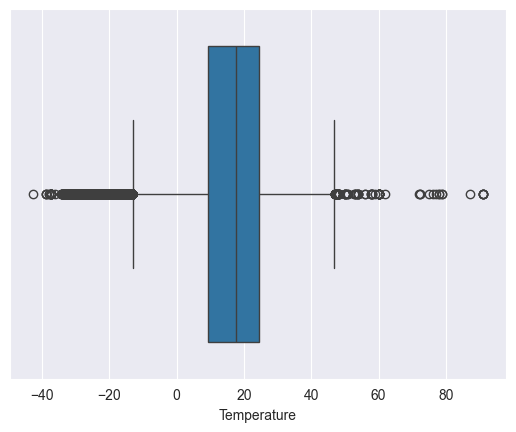

In [176]:
#dropping accidents with more than 60 degree as the highest temperature ever recorded is only 53 degree celsius
#while the extreme negative degree is well within expectation
pd.set_option('display.max_columns', 200)
df[df.Temperature > 50]
sns.boxplot(df, x = 'Temperature')

df = df[df['Temperature'] < 60]

<Axes: xlabel='Wind_Chill'>

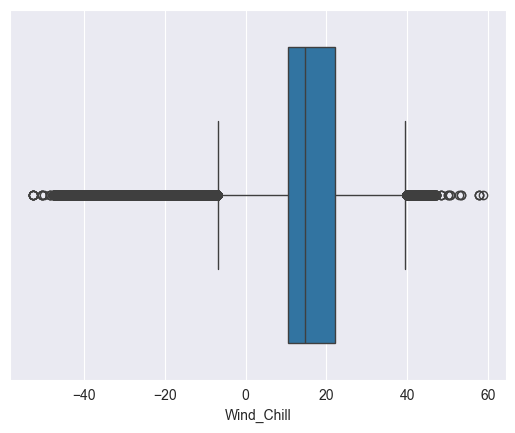

In [177]:
#transforming wind_chill to celsius
#also wind temperature looks within possibility

df.Wind_Chill = (df.Wind_Chill - 32) * 5 / 9
sns.boxplot(df, x='Wind_Chill')

In [178]:
df['Wind_Direction'].value_counts().sort_index()

Wind_Direction
CALM        942796
Calm        362598
E           274727
ENE         254931
ESE         264812
East        102539
N           302063
NE          254648
NNE         251635
NNW         328353
NW          364391
North       137057
S           413900
SE          291134
SSE         344111
SSW         379701
SW          359825
South       175514
VAR         247141
Variable    112077
W           378396
WNW         373372
WSW         348591
West        162387
Name: count, dtype: int64

In [179]:
#some of the values are the same ie. VAR and Variable, North and N, West and W, East and E, South and S, CALM and Calm
WDmap = {'Calm':'CALM',
         'East':'E',
         'North':'N',
         'South':'S',
         'West':'W',
         'Variable':'VAR',
        }
df['Wind_Direction'] = df['Wind_Direction'].replace(WDmap)

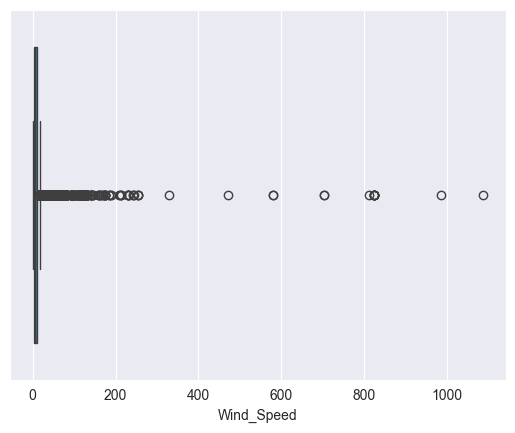

In [180]:
# maximum windspeed in US that is recorded is 231mph, so deleting all wind_speed rows with windspeed higher than 230
# changing mph to mps
#https://wmo.asu.edu/content/northern-hemisphere-highest-wind
sns.boxplot(df, x = 'Wind_Speed')
df = df[df['Wind_Speed']<231]
df['Wind_Speed'] = df['Wind_Speed'] * 0.44704

<Axes: xlabel='Precipitation'>

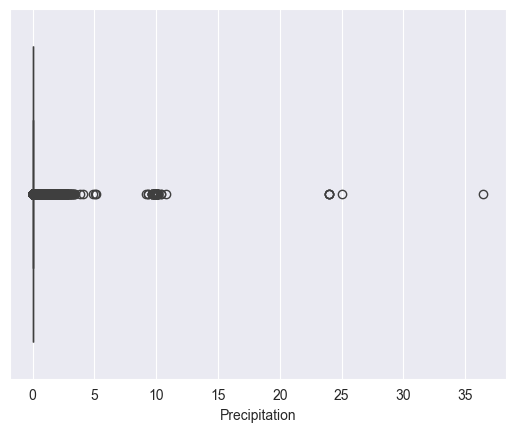

In [181]:
sns.boxplot(df, x = 'Precipitation')

In [182]:
# going to make the decision to remove precipitation over 20in as they are really big outliers
# also changing the unit from in to mm
df = df[df['Precipitation'] < 20]
df['Precipitation'] = df['Precipitation'] * 25.4



In [183]:
#too many weather conditions. narrow to these main types, Sunny, Cloudy, Rainy, Snowy, Thunder, storm, Tornados
#https://www.twinkl.com.sg/teaching-wiki/different-types-of-weather-conditions#:~:text=Different%20types%20of%20weather%20conditions,-There%20are%20many&text=The%20five%20main%20types%20of,of%20the%20global%20weather%20system.
pd.set_option('display.max_row', 200)
df['Weather_Condition'].value_counts()
df['Sunny'] = df['Weather_Condition'].str.contains('fair|clear', case = False)
df['Rainy'] = df['Weather_Condition'].str.contains('rain|shower|drizzle|precipitation', case = False)
df['Cloudy'] = df['Weather_Condition'].str.contains('Fog|Cloud|Haze|dust|Mist|overcast|smoke|ash', case = False)
df['Snowy'] = df['Weather_Condition'].str.contains('snow|hail|sleet|ice|wintry', case = False)
df['Thunder'] = df['Weather_Condition'].str.contains('thunder|T-Storm', case = False)
df['Storm'] = df['Weather_Condition'].str.contains('storm|T-Storm|Squalls', case = False)
df['Tornado'] = df['Weather_Condition'].str.contains('Tornado', case = False)



In [184]:
df.to_csv('US Accident(clean).csv')